# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [49]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


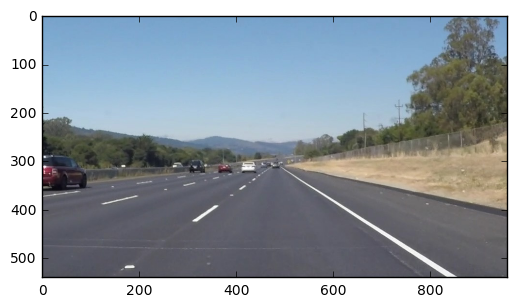

In [50]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [51]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def hsv_transform(img):
    """Applies HSV transform to extract yellow and white color channels."""
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Define range for yellow channel.
    yellow = np.uint8([[[232,200,117]]])
    yellow_hsv = cv2.cvtColor(yellow, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([yellow_hsv[0][0][0]-30, 100, 100])
    upper_yellow = np.array([yellow_hsv[0][0][0]+30, 255, 255])
    # Threshold the image to get only yellow values.
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    # Define range for white channel.
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([255, 255, 255])
    # Threshold the image to get only white values.
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise OR the masks
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    # Bitwise AND mask with original image
    res = cv2.bitwise_and(img, img, mask=mask)
    return res
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [52]:
import os
os.listdir("test_images/")

['.DS_Store',
 'lines-solidWhiteCurve.jpg',
 'lines-solidWhiteRight.jpg',
 'lines-solidYellowCurve.jpg',
 'lines-solidYellowCurve2.jpg',
 'lines-solidYellowLeft.jpg',
 'lines-whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [53]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

prev_left_line = np.zeros(4, dtype=np.uint32)
prev_left_slope = 0
prev_right_line = np.zeros(4, dtype=np.uint32)
prev_right_slope = 0

def reset_metrics():
    global prev_left_line, prev_left_slope
    global prev_right_line, prev_right_slope
    prev_left_line = np.zeros(4, dtype=np.uint32)
    prev_left_slope = 0
    prev_right_line = np.zeros(4, dtype=np.uint32)
    prev_right_slope = 0
    
def cluster_nearby_points(points):
    left_points = []
    right_points = []
    which_side = -1
    for line_points in points:
        which_side += 1
        clusters = []
        # For every point on this line...
        for i in range(0, len(line_points)):
            # Skip this point if it's already in a cluster.
            already_in_cluster = False
            for cluster in clusters:
                if already_in_cluster:
                    break
                for idx in cluster:
                    if idx == i:
                        already_in_cluster = True
                        break
            if already_in_cluster:
                continue
            clusters.append([i])
            x = line_points[i][0]
            y = line_points[i][1]
            # Find distance between this point and all other points.
            for j in range(i+1, len(line_points)):
                # Skip this point if it's already in a cluster.
                already_in_cluster = False
                for cluster in clusters:
                    if already_in_cluster:
                        break
                    for idx in cluster:
                        if idx == j:
                            already_in_cluster = True
                            break
                if already_in_cluster:
                    continue
                px = line_points[j][0]
                py = line_points[j][1]
                dx = px-x
                dy = py-y
                dist = math.sqrt((dx*dx)+(dy*dy))
                if dist < 35:
                    # This point (i) is near another point (j)!
                    clusters[len(clusters)-1].append(j)
        # Make new points by averaging clusters together.
        for cluster in clusters:
            new_p = np.array([0,0])
            for p in cluster:
                new_p += line_points[p]
            new_p = new_p/len(cluster)
            if which_side == 0:
                left_points.append(np.array(new_p, dtype=np.uint32))
            else:
                right_points.append(np.array(new_p, dtype=np.uint32))
    # Sort points by x-value (ascending).
    left_points.sort(key=lambda x: x[0])
    right_points.sort(key=lambda x: x[0])
    return left_points, right_points

def calc_best_fit(points):
    # Get line means.
    x = []
    y = []
    for p in points:
        x.append(p[0])
        y.append(p[1])
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # Calculate line slope.
    top = 0
    bottom = 0
    for p in points:
        top += (p[0]-mean_x)*(p[1]-mean_y)
        bottom += (p[0]-mean_x)*(p[0]-mean_x)
    slope = top/bottom
    b = mean_y - (slope*mean_x)
    return slope, b

def line_within_bounds(line, w, h):
    if line[0] >= 0 and line[0] <= w \
            and line[1] >= 0 and line[1] <= h \
            and line[2] >= 0 and line[2] <= w \
            and line[3] >= 0 and line[3] <= h:
                return True
    else:
        return False
    
def create_line_extended(m, y, b, w, h):
    line = np.zeros(4, dtype=np.uint32)
    # Extend line using slope and y-intercept.
    # Only allow line with reasonable slope.
    if abs(m) < 0.01 or abs(m) > 100:
        line[0] = -1
        line[2] = -1
    else:
        line[0] = max(-1, min(w+1, (1/m)*(y-b)))
        line[2] = max(-1, min(w+1, (1/m)*(h-y) + line[0]))
    line[1] = y
    line[3] = h
    return line
    
def group_lines(lines, w, h):
    global prev_left_line, prev_left_slope
    global prev_right_line, prev_right_slope
    
    # Group points from lines according to slope
    left_highest_y = 0
    right_highest_y = 0
    left_points = [] # all points to form left lane
    right_points = [] # all points to form right lane
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y1-y2)/(x1-x2)
            if m < -0.2 and m > -0.9:
                # left lane
                left_points.append([x1,y1])
                left_points.append([x2,y2])
                if left_highest_y == 0 or y1 < left_highest_y:
                    left_highest_y = y1
                if left_highest_y == 0 or y2 < left_highest_y:
                    left_highest_y = y2
            elif m > 0.2 and m < 0.9:
                # right lane
                right_points.append([x1,y1])
                right_points.append([x2,y2])
                if right_highest_y == 0 or y1 < right_highest_y:
                    right_highest_y = y1
                if right_highest_y == 0 or y2 < right_highest_y:
                    right_highest_y = y2
        
    # Cluster nearby points
    points = [left_points, right_points]
    left_points, right_points = cluster_nearby_points(points)
    
    # Create lines of best fit from points.
    best_left_slope, best_left_b = calc_best_fit(left_points)
    # print("left: y={0}x+{1}".format(best_left_slope,best_left_b))
    best_right_slope, best_right_b = calc_best_fit(right_points)
    # print("right: y={0}x+{1}".format(best_right_slope,best_right_b))
    
    # Create lines to draw over lanes.
    left_line = create_line_extended(best_left_slope, left_highest_y, best_left_b, w, h)
    right_line = create_line_extended(best_right_slope, right_highest_y, best_right_b, w, h)
    
    # Make sure line is valid. If not, use previous line.
    if line_within_bounds(left_line, w, h) \
            and (prev_left_slope == 0 or \
                 abs(prev_left_slope - best_left_slope) < 0.1):
        prev_left_line = left_line
        prev_left_slope = best_left_slope
    else:
        left_line = prev_left_line
    if line_within_bounds(right_line, w, h) \
            and (prev_right_slope == 0 or \
                 abs(prev_right_slope - best_right_slope) < 0.1):
        prev_right_line = right_line
        prev_right_slope = best_right_slope
    else:
        right_line = prev_right_line
    
    return left_line, right_line

def detect_lines(image):
    # HSV transform the image
    hsv = hsv_transform(image)
    
    # Grayscale the image
    gray = grayscale(hsv)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 40
    high_threshold = 100
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Mask with vertices
    imshape = image.shape
    w = imshape[1]
    h = imshape[0]
    vertices = np.array([[(0,h), \
                          ((w/2)-10, (h/2)+50), \
                          ((w/2)+10, (h/2)+50), \
                          (w,h)]], \
                        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = (np.pi/180) # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 150    # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), \
                            min_line_length, max_line_gap)
    
    # Group hough lines into left and right.
    left_line, right_line = group_lines(lines, w, h)
    
    # Draw lines on blank image
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    lane_lines = np.array([[left_line], [right_line]])
    draw_lines(line_image, lane_lines, color=[255, 0, 0], thickness=8)

    # Draw the lines on the original image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    
    # return image with lines drawn on it
    return lines_edges

for filename in os.listdir("test_images/"):
    if ".jpg" not in filename or "lines-" in filename:
        continue
    image = mpimg.imread("test_images/"+filename)
    reset_metrics()
    lines_image = detect_lines(image)
    mpimg.imsave("test_images/lines-"+filename, lines_image)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [54]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [55]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = detect_lines(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [56]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
reset_metrics()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 47.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.98 s, sys: 1.97 s, total: 6.95 s
Wall time: 5.19 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [58]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
reset_metrics()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:14<00:00, 48.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 15.4 s, sys: 6.36 s, total: 21.8 s
Wall time: 14.7 s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### My thoughts

This was a challenge for me to get right, but I'm pretty happy with my final result. At first, my approach was fairly basic: (1) capture all the line segments using canny+hough, (2) group segments into "left" or "right" based on positive or negative slope, and (3) create a line for each lane by calculating the average slope and the minimum x-value and y-value of all the line segments in the group, and extending a line from this coordinate to the bottom of the frame. However, this did not always work well, since the minimum x-value and y-value does not always correlate with the center of the lane, and the average slope of all the line segments does not necessarily match the actual slope of the lane lines, nor does it always line up with the lane when extended from the aforementioned coordinate.

To improve on this method, I tried storing the previous lines and slopes in global variables, and using these values as weights when I was calculating a new slope and line coordinates. This worked slightly better, since the average value of my coordinates/slopes tended toward a correct solution, but the lines were still inaccurate and very jittery.

When this didn't work, I decided to try a completely different approach. First, I tweaked my parameters for my hough and canny algorithms to get better line segments. This meant allowing for longer line segments and bigger gaps between them, as well as giving a lower upper bound for my canny algorithm. I still separate the line segments into "left" and "right" groups based on slope, but for the rest of my calculations, my algorithm ignores the line segments and instead simply groups all of the points from the line segments into clusters based on proximity to each other. If 2 or more points from any line segment(s) are less than 35 pixels apart, they are averaged together to make one single point on the image. This gives me a scatter plot for the left and right lanes. Then, I calculate the line of best fit for both scatter plots, using the minimum y-value and extending down to the bottom of the frame. This approach resulted in much more accurate and consistent lines, and this is what I used for my final solution.

Finally, since it still wasn't working great for the challenge video, I decided to apply an HSV transform to filter out everything except yellow and white values from the image before proceeding with grayscale, gaussian blur, etc. This made my solution for the challenge video significantly better, although it is still a bit jittery. If I were to work on this algorithm some more, I would try to include my previous approach of weighting the slopes and line coordinates based on previous values in order to smooth out the lines.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [60]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
reset_metrics()
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:10<00:00, 26.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 11.1 s, sys: 3.33 s, total: 14.4 s
Wall time: 12 s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))